<span style="font-family: Arial; font-size:1.6em;color:lightblue;"><b> Proyecto Integrador </b><br>
Comisión 1120-ed-13<br>Notebook 2</p>

--------------------

## Grupo 1 - Integrantes

* Oviedo, Cecilia
* Sosa, Gonzalo
* Suchecki, Rocío


--------------------

<a id="section_toc"></a> 

## Tabla de Contenidos

### [1- Imports](#section_imports)  

### [2- Base de datos](#section_dataset)
  - [Carga del dataset](#section_carga)

### [3- Modelado](#section_modelado)
  - [a. Regresión Lineal](#section_lineal)
  - [b. XGBoost](#section_XGBoost)  
  - [c. Random Forest](#section_RF)
  - [d. SVR (Support Vector Regression)](#section_SVR)
  - [e. AdaBoost](#section_ada)
  

### [4- Gráficos comparativos de los modelos](#section_graficos)
---

<a id="section_imports"></a> 
# 1- Imports

[volver a TOC](#section_toc)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet, LassoCV, RidgeCV
from sklearn.metrics import r2_score
from sklearn import linear_model
import xgboost as xgb
from sklearn.svm import SVR
import itertools 
import warnings

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

palette='cubehelix'
cmap='cubehelix'

<a id="section_dataset"></a> 
# 2- Base de datos

[volver a TOC](#section_toc)

<a id="section_carga"></a> 
## **Carga del dataset**
[volver a TOC](#section_toc)

In [2]:
#Cargamos el dataset generado tras el análisis previo y la eliminación de outliers
df_clean=pd.read_csv('Base_TP_clean.csv',sep=";",encoding='utf-8')

<a id="section_modelado"></a> 
# 1- Modelado

[volver a TOC](#section_toc)

Ya tenemos identificadas columnas en ARS, y transformamos a USD con el tipo de cambio oficial. Vamos a considerar una opción a partir del dato del tipo de cambio no oficial (Blue).

In [3]:
df_clean['Cost_USD_Blue']=df_clean.Cost/df_clean.FX_Loss_Date_prev_Blue
df_clean['Product_Purchase_Price_USD_Blue']=df_clean.Product_Purchase_Price/df_clean.FX_Sales_Date_Blue

En primer lugar separamos las features y el target para luego utilizarlas en los diferentes modelos.

In [4]:
y = df_clean[['Cost','Cost_USD','Cost_USD_Blue']]
X = df_clean.drop(['Cost','Cost_USD','Cost_USD_Blue'], axis=1)
mask_repair=df_clean.Solution=='Repair'
mask_replace=df_clean.Solution!='Repair'

Hacemos una lista de features numericas y categoricas para posteriormente aplicar procesamientos independientes

In [5]:
numericas = [i for i in X.columns if X[i].dtypes != 'object' ]
categoricas = [i for i in X.columns if X[i].dtypes == 'object' ]
categoricas.remove('Product_Group_Solution') #Esta fue creada para el análisis exploratorio pero no es más que una combinación del resto de las features.

A continuación definimos distintas listas de columnas numericas y categoricas para probar más adelante la mejor combinación de features en un gridsearch

In [6]:
numericas_ARS_oficial = ['FX_Sales_Date','FX_Loss_Date_prev','Months_at_loss','Product_Purchase_Price']
numericas_ARS_blue = ['FX_Sales_Date_Blue','FX_Loss_Date_prev_Blue','Months_at_loss','Product_Purchase_Price']
numericas_USD_oficial = ['Months_at_loss','Product_Purchase_Price_USD','FX_Loss_Date_prev']
numericas_USD_blue = ['Months_at_loss','Product_Purchase_Price_USD_Blue','FX_Loss_Date_prev_Blue']

# Dejaremos también separadas las categóricas
categoricas_sin_product_code = categoricas.copy()
categoricas_sin_product_code.remove('Product_Code')

#Para los reemplazos no es necesaria la feature "Service Center" ya que es exclusiva de las reparaciones
categoricas_replace=categoricas.copy()
categoricas_replace.remove('Solution')
categoricas_replace.remove('Service_Center')

Hacemos el split de entrenamiento y testeo

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=X.Solution)
X_train_repair, X_test_repair, y_train_repair, y_test_repair = train_test_split(X[mask_repair], y[mask_repair], test_size=0.3, random_state=42)
X_train_replace, X_test_replace, y_train_replace, y_test_replace = train_test_split(X[mask_replace], y[mask_replace], test_size=0.3, random_state=42)

In [8]:
# Clase para seleccionar columnas
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    
    def transform(self, X, *_):
        if isinstance(X, pd.DataFrame):
            return pd.DataFrame(X[self.columns])
        else:
            raise TypeError("Este Transformador solo funciona en DF de Pandas")
    
    def fit(self, X, *_):
        return self

A continuación definimos una función general para fitear los modelos.  
Lo que hace la función es recibir un pipeline y un listado de parámetros a probar. Luego ejecuta la busqueda de parámetros a través de un GridSearchCV, y permite obtener los scores divididos entre reparación/reemplazo y entre train y test.

In [9]:
def modelado(full_pipe,param_grid,X_train,X_test,y_train,y_test):
    grid = GridSearchCV(full_pipe, param_grid, scoring='r2',n_jobs=-1, verbose=10)
    grid.fit(X_train, y_train)
    y_pred = grid.best_estimator_.predict(X_test)
    y_train_pred=grid.best_estimator_.predict(X_train)
    
    #Print de los scores para modelo general:
    print(f'\nLos mejores parametros son: {grid.best_params_}')
    print(f'\nR2 en train: {r2_score(y_train,y_train_pred)}')
    print(f'R2 en test: {r2_score(y_test,y_pred)}')
    r2_repair_test = 0
    r2_replace_test = 0
    #Print de los scores para modelos de reparaciones
    if len(X_train.Solution.unique())==2:
        try:
            mask_repair=X_train.Solution=='Repair'
            r2_repair_train = r2_score(y_train[mask_repair],y_train_pred[mask_repair])
            print(f'\nR2 en train reparaciones: {r2_repair_train}')
            mask_repair=X_test.Solution=='Repair'
            r2_repair_test = r2_score(y_test[mask_repair],y_pred[mask_repair])
            print(f'R2 en test reparaciones: {r2_repair_test}')
            print(y_test[mask_repair].shape)
            print(y_pred[mask_repair].shape)
        except : 
            pass
        
    #Print de los scores para modelos de reemplazos en Train
        try: 
            mask_replacement=X_train.Solution!='Repair'
            r2_replace_train = r2_score(y_train[mask_replacement],y_train_pred[mask_replacement])
            print(f'\nR2 en train reemplazos: {r2_replace_train}')
            mask_replacement=X_test.Solution!='Repair'
            r2_replace_test = r2_score(y_test[mask_replacement],y_pred[mask_replacement])
            print(f'R2 en test reemplazos: {r2_replace_test}')
            print(y_test[mask_replacement].shape)
            print(y_pred[mask_replacement].shape)
        except :
            pass  
    else:
        pass
    if r2_repair_test and r2_replace_test != 0:
        return y_train_pred,y_pred,r2_repair_test,r2_replace_test
    else:
        return y_train_pred,y_pred

Vamos a construir un pipeline que procese por separado las variables categóricas y las numéricas, luego ambos procesos se unen y se construye el Pipeline final que consta del paso mencionado y el modelo a implementar.

In [10]:
#Pipeline para categóricas y numéricas
pipe_num = Pipeline([("select_num", ColumnSelector(numericas)),("scale", StandardScaler())])
pipe_cat = Pipeline([("select_cat", ColumnSelector(categoricas)),("ohe", OneHotEncoder(handle_unknown='ignore'))])
union = FeatureUnion([("numericas", pipe_num),("categoricas", pipe_cat)])
full_pipe = Pipeline([("preprocessing", union),("rgr", None)])

<a id="section_lineal"></a> 
## **a. Baseline: Regresión Lineal**
[volver a TOC](#section_toc)

La Regresión lineal será nuestro modelo base para determinar el resultado mínimo que esperamos predecir.   
Empezamos con un modelo para el total del dataset (sin distinción por tipo de solución). 

In [11]:
param_grid_L = [{"preprocessing__numericas__select_num__columns":[numericas_ARS_oficial,numericas_ARS_blue,numericas_USD_oficial,numericas_USD_blue],
                      "preprocessing__categoricas__select_cat__columns":[categoricas,categoricas_sin_product_code],
        "rgr": [linear_model.LinearRegression()],
         }]

y_train_pred_L, y_test_pred_L,r2_repair_test_L,r2_replace_test_L= modelado(full_pipe,param_grid_L,X_train,X_test,y_train.Cost,y_test.Cost)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:   18.4s remaining:    6.1s
[Parallel(n_jobs=-1)]: Done  35 out of  40 | elapsed:   21.0s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   21.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   21.5s finished



Los mejores parametros son: {'preprocessing__categoricas__select_cat__columns': ['Dealer', 'Product_Group', 'Product_SubGroup', 'Product_Code', 'Manufacturer', 'Model', 'Solution', 'Service_Center'], 'preprocessing__numericas__select_num__columns': ['FX_Sales_Date', 'FX_Loss_Date_prev', 'Months_at_loss', 'Product_Purchase_Price'], 'rgr': LinearRegression()}

R2 en train: 0.682077895687592
R2 en test: 0.5592677535294479

R2 en train reparaciones: 0.060144431334920645
R2 en test reparaciones: -0.31513004481454754
(6154,)
(6154,)

R2 en train reemplazos: 0.679292588218987
R2 en test reemplazos: 0.5634377418494274
(1514,)
(1514,)


Las variables utilizadas por el mejor modelo fueron los datos en ARS con el tipo de cambio oficial como feature, y además el modelo elige no utilizar el product_code como feature, entendemos porque de alguna manera esa variable se repite en el resto.  

Vamos a probar modelo baseline separando entre reparación y reemplazo.

In [12]:
#Para reparaciones
print('\nModelo Reparaciones:')
print('--------------------')
param_grid_L = [{"preprocessing__numericas__select_num__columns":[numericas_ARS_oficial,numericas_ARS_blue,numericas_USD_oficial,numericas_USD_blue],
                      "preprocessing__categoricas__select_cat__columns":[categoricas,categoricas_sin_product_code],
        "rgr": [linear_model.LinearRegression()],
        }]

y_train_pred_repair_L, y_test_pred_repair_L= modelado(full_pipe,param_grid_L,X_train_repair,X_test_repair,y_train_repair.Cost,y_test_repair.Cost)

#Para reemplazos 
print('\nModelo Reemplazos:')
print('--------------------')
param_grid_L = [{"preprocessing__numericas__select_num__columns":[numericas_ARS_oficial,numericas_ARS_blue,numericas_USD_oficial,numericas_USD_blue],
                      "preprocessing__categoricas__select_cat__columns":[categoricas,categoricas_sin_product_code],
        "rgr": [linear_model.LinearRegression()],
        }]

y_train_pred_replace_L, y_test_pred_replace_L = modelado(full_pipe,param_grid_L,X_train_replace,X_test_replace,y_train_replace.Cost,y_test_replace.Cost)


Modelo Reparaciones:
--------------------
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:   13.6s remaining:    4.5s
[Parallel(n_jobs=-1)]: Done  35 out of  40 | elapsed:   15.5s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   15.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   15.9s finished



Los mejores parametros son: {'preprocessing__categoricas__select_cat__columns': ['Dealer', 'Product_Group', 'Product_SubGroup', 'Manufacturer', 'Model', 'Solution', 'Service_Center'], 'preprocessing__numericas__select_num__columns': ['FX_Sales_Date', 'FX_Loss_Date_prev', 'Months_at_loss', 'Product_Purchase_Price'], 'rgr': LinearRegression()}

R2 en train: 0.5255362582755301
R2 en test: 0.35560444213826736

Modelo Reemplazos:
--------------------
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    1.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  35 out of  40 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.3s finished



Los mejores parametros son: {'preprocessing__categoricas__select_cat__columns': ['Dealer', 'Product_Group', 'Product_SubGroup', 'Manufacturer', 'Model', 'Solution', 'Service_Center'], 'preprocessing__numericas__select_num__columns': ['FX_Sales_Date_Blue', 'FX_Loss_Date_prev_Blue', 'Months_at_loss', 'Product_Purchase_Price'], 'rgr': LinearRegression()}

R2 en train: 0.901518541892804
R2 en test: 0.7379851156489703


Vemos que performan mucho mejor en ambos tipos de solución, tener modelos por separado para reparaciones y para reemplazos.

<a id="section_XGBoost"></a> 
## **b. XGBoost**
[volver a TOC](#section_toc)

Teniendo un modelo base con scores de partida, y sabiendo que el baseline performa mejor con modelos separados por tipo de solución, probaremos XGBoost para ver como mejora la predicción.

In [13]:
#Un unico modelo para el total del dataset
param_grid_XG = [{"preprocessing__numericas__select_num__columns":[numericas_ARS_oficial,numericas_ARS_blue,numericas_USD_oficial,numericas_USD_blue],
                      "preprocessing__categoricas__select_cat__columns":[categoricas,categoricas_sin_product_code],
        "rgr": [xgb.XGBRegressor()]        
        }]
y_train_pred_XG, y_test_pred_XG, r2_repair_test_XG,r2_replace_test_XG = modelado(full_pipe,param_grid_XG,X_train,X_test,y_train.Cost,y_test.Cost)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:   13.0s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done  35 out of  40 | elapsed:   15.6s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   16.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   16.1s finished



Los mejores parametros son: {'preprocessing__categoricas__select_cat__columns': ['Dealer', 'Product_Group', 'Product_SubGroup', 'Product_Code', 'Manufacturer', 'Model', 'Solution', 'Service_Center'], 'preprocessing__numericas__select_num__columns': ['FX_Sales_Date', 'FX_Loss_Date_prev', 'Months_at_loss', 'Product_Purchase_Price'], 'rgr': XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)}

R2 en train: 0.89218210484426
R2 e

In [14]:
#Modelos diferentes por tipo de solucion

print('\nModelo Reparaciones:')
print('--------------------')
param_grid_repair_XG = [{"preprocessing__numericas__select_num__columns":[numericas_ARS_oficial,numericas_ARS_blue,numericas_USD_oficial,numericas_USD_blue],
                      "preprocessing__categoricas__select_cat__columns":[categoricas,categoricas_sin_product_code],
        "rgr": [xgb.XGBRegressor()]        
        }]
y_train_pred_repair_XG, y_test_pred_repair_XG = modelado(full_pipe,param_grid_repair_XG,X_train_repair,X_test_repair,y_train_repair.Cost,y_test_repair.Cost)


print('\nModelo Reemplazos:')
print('--------------------')
param_grid_replace_XG = [{"preprocessing__numericas__select_num__columns":[numericas_ARS_oficial,numericas_ARS_blue,numericas_USD_oficial,numericas_USD_blue],
                      "preprocessing__categoricas__select_cat__columns":[categoricas_replace],
        "rgr": [xgb.XGBRegressor()]        
        }]
y_train_pred_replace_XG, y_test_pred_replace_XG = modelado(full_pipe,param_grid_replace_XG,X_train_replace,X_test_replace,y_train_replace.Cost,y_test_replace.Cost)


Modelo Reparaciones:
--------------------
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:   10.8s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  35 out of  40 | elapsed:   13.2s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   13.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   13.5s finished



Los mejores parametros son: {'preprocessing__categoricas__select_cat__columns': ['Dealer', 'Product_Group', 'Product_SubGroup', 'Manufacturer', 'Model', 'Solution', 'Service_Center'], 'preprocessing__numericas__select_num__columns': ['FX_Sales_Date', 'FX_Loss_Date_prev', 'Months_at_loss', 'Product_Purchase_Price'], 'rgr': XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)}

R2 en train: 0.6026754909499615
R2 en test: 0.4420

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:    1.1s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:    2.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  14 out of  20 | elapsed:    2.1s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:    2.7s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    2.7s finished



Los mejores parametros son: {'preprocessing__categoricas__select_cat__columns': ['Dealer', 'Product_Group', 'Product_SubGroup', 'Product_Code', 'Manufacturer', 'Model'], 'preprocessing__numericas__select_num__columns': ['FX_Sales_Date_Blue', 'FX_Loss_Date_prev_Blue', 'Months_at_loss', 'Product_Purchase_Price'], 'rgr': XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)}

R2 en train: 0.95917757494798
R2 en test: 0.7995413842

Se observa el mismo comportamiento que en el modelo básico, ambos modelos mejoran si utilizamos modelos distintos.  
Vamos a graficar los resultados:

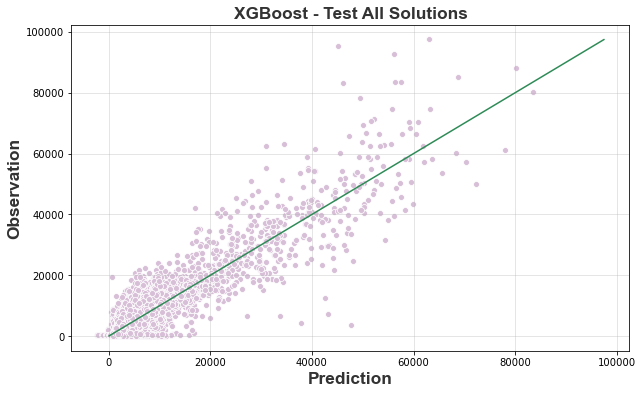

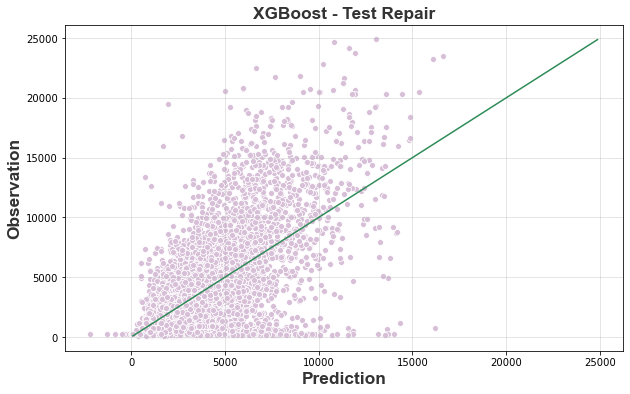

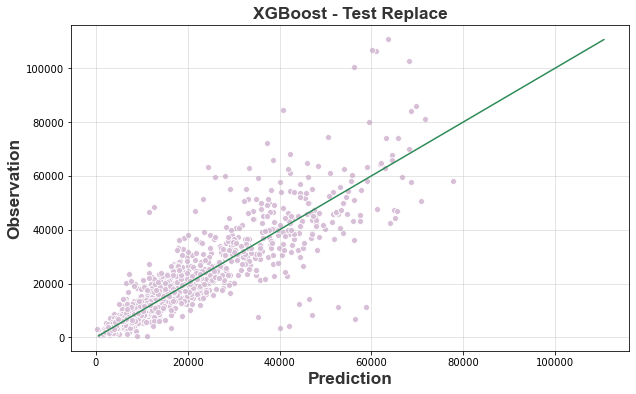

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))
with sns.axes_style('darkgrid'):
    g = sns.scatterplot(x=y_test_pred_XG,y=y_test['Cost'],ax=ax,color='Thistle')
    g = sns.lineplot(x = y_test['Cost'] , y = y_test['Cost'],color="SeaGreen")
    g.set_xlabel('Prediction',weight='bold',size='xx-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    g.set_ylabel('Observation',weight='bold',size='xx-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    g.set_title('XGBoost - Test All Solutions',weight='bold',size='xx-large',alpha=0.8,family= 'Arial',stretch='extra-expanded') 
    g.grid(alpha=0.4)
    
fig, ax = plt.subplots(figsize=(10, 6))
with sns.axes_style('darkgrid'):
    g = sns.scatterplot(x=y_test_pred_repair_XG,y=y_test_repair['Cost'],ax=ax,color='Thistle')
    g = sns.lineplot(x = y_test_repair['Cost'] , y = y_test_repair['Cost'],color="SeaGreen")
    g.set_xlabel('Prediction',weight='bold',size='xx-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    g.set_ylabel('Observation',weight='bold',size='xx-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    g.set_title('XGBoost - Test Repair',weight='bold',size='xx-large',alpha=0.8,family= 'Arial',stretch='extra-expanded') 
    g.grid(alpha=0.4)
    
fig, ax = plt.subplots(figsize=(10, 6))
with sns.axes_style('darkgrid'):
    g = sns.scatterplot(x=y_test_pred_replace_XG,y=y_test_replace['Cost'],ax=ax,color='Thistle')
    g = sns.lineplot(x = y_test_replace['Cost'] , y = y_test_replace['Cost'],color="SeaGreen")
    g.set_xlabel('Prediction',weight='bold',size='xx-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    g.set_ylabel('Observation',weight='bold',size='xx-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    g.set_title('XGBoost - Test Replace',weight='bold',size='xx-large',alpha=0.8,family= 'Arial',stretch='extra-expanded') 
    g.grid(alpha=0.4)

<a id="section_RF"></a> 
## **c. Random Forest**
[volver a TOC](#section_toc)

Implementamos un modelo Random Forest.   
Como este modelo demora un significativo tiempo vamos a pasar las features que resultaron en mejores puntajes en los modelos anteriores.

In [16]:
# Grilla de parámetros
param_grid_RF = [{"preprocessing__numericas__select_num__columns":[numericas_ARS_oficial],
                      "preprocessing__categoricas__select_cat__columns":[categoricas_sin_product_code],
        "rgr": [RandomForestRegressor()]        
        }]
#Fit
y_train_pred_RF, y_test_pred_RF,r2_repair_test_RF,r2_replace_test_RF = modelado(full_pipe,param_grid_RF,X_train,X_test,y_train.Cost,y_test.Cost)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.8min remaining:  2.7min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.8min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished



Los mejores parametros son: {'preprocessing__categoricas__select_cat__columns': ['Dealer', 'Product_Group', 'Product_SubGroup', 'Manufacturer', 'Model', 'Solution', 'Service_Center'], 'preprocessing__numericas__select_num__columns': ['FX_Sales_Date', 'FX_Loss_Date_prev', 'Months_at_loss', 'Product_Purchase_Price'], 'rgr': RandomForestRegressor()}

R2 en train: 0.9735114415439702
R2 en test: 0.8181393077843806

R2 en train reparaciones: 0.9160964804427241
R2 en test reparaciones: 0.38724571575608446
(6154,)
(6154,)

R2 en train reemplazos: 0.97479643041881
R2 en test reemplazos: 0.8395962484863788
(1514,)
(1514,)


Vemos que este modelo comparado con el de XGBoost tiene mejores score en train, pero casi idénticos scores en test.

Probaremos como performan los modelos por tipo de solución.

In [17]:
print('\nModelo Reparaciones:')
print('--------------------')
y_train_pred_repair_RF, y_test_pred_repair_RF = modelado(full_pipe,param_grid_RF,X_train_repair,X_test_repair,y_train_repair.Cost,y_test_repair.Cost)

print('\nModelo Reemplazos:')
print('--------------------')

param_grid_replace_RF = [{"preprocessing__numericas__select_num__columns":[numericas_ARS_oficial],
                      "preprocessing__categoricas__select_cat__columns":[categoricas_replace],
        "rgr": [RandomForestRegressor()]        
        }]

y_train_pred_replace_RF, y_test_pred_replace_RF = modelado(full_pipe,param_grid_replace_RF,X_train_replace,X_test_replace,y_train_replace.Cost,y_test_replace.Cost)


Modelo Reparaciones:
--------------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.3min remaining:  2.0min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.3min remaining:   53.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished



Los mejores parametros son: {'preprocessing__categoricas__select_cat__columns': ['Dealer', 'Product_Group', 'Product_SubGroup', 'Manufacturer', 'Model', 'Solution', 'Service_Center'], 'preprocessing__numericas__select_num__columns': ['FX_Sales_Date', 'FX_Loss_Date_prev', 'Months_at_loss', 'Product_Purchase_Price'], 'rgr': RandomForestRegressor()}

R2 en train: 0.9141815686604868
R2 en test: 0.4056815129878153

Modelo Reemplazos:
--------------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.9s remaining:   14.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    9.9s remaining:    6.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.0s finished



Los mejores parametros son: {'preprocessing__categoricas__select_cat__columns': ['Dealer', 'Product_Group', 'Product_SubGroup', 'Product_Code', 'Manufacturer', 'Model'], 'preprocessing__numericas__select_num__columns': ['FX_Sales_Date', 'FX_Loss_Date_prev', 'Months_at_loss', 'Product_Purchase_Price'], 'rgr': RandomForestRegressor()}

R2 en train: 0.9779514356403975
R2 en test: 0.8138443421864257


Graficamos el ajuste:

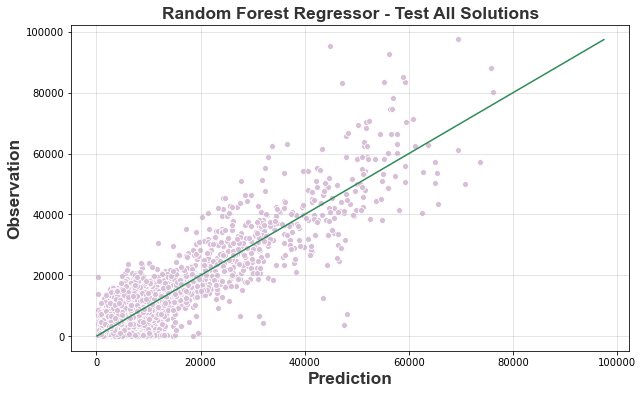

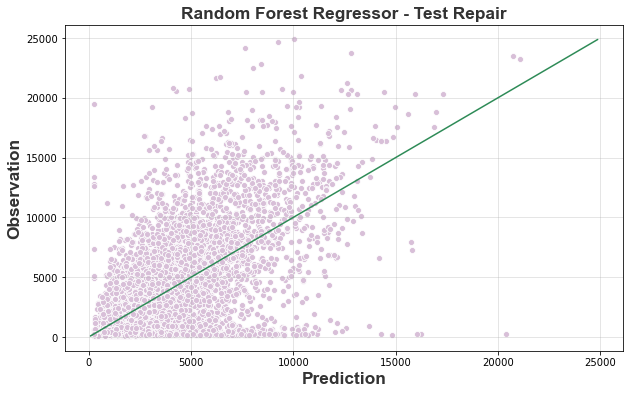

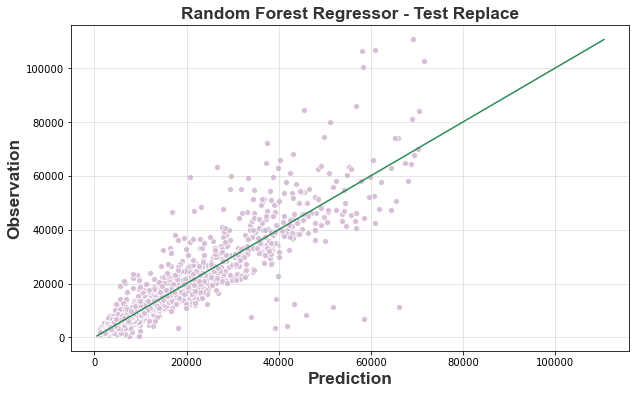

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))
with sns.axes_style('darkgrid'):
    g = sns.scatterplot(x=y_test_pred_RF,y=y_test['Cost'],ax=ax,color='Thistle')
    g = sns.lineplot(x = y_test['Cost'] , y= y_test['Cost'], color="SeaGreen")
    g.set_xlabel('Prediction',weight='bold',size='xx-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    g.set_ylabel('Observation',weight='bold',size='xx-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    g.set_title('Random Forest Regressor - Test All Solutions',weight='bold',size='xx-large',alpha=0.8,family= 'Arial',stretch='extra-expanded') 
    g.grid(alpha=0.4)
    
fig, ax = plt.subplots(figsize=(10, 6))
with sns.axes_style('darkgrid'):
    g = sns.scatterplot(x=y_test_pred_repair_RF,y=y_test_repair['Cost'],ax=ax,color='Thistle')
    g = sns.lineplot(x = y_test_repair['Cost'] , y= y_test_repair['Cost'], color="SeaGreen")
    g.set_xlabel('Prediction',weight='bold',size='xx-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    g.set_ylabel('Observation',weight='bold',size='xx-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    g.set_title('Random Forest Regressor - Test Repair',weight='bold',size='xx-large',alpha=0.8,family= 'Arial',stretch='extra-expanded') 
    g.grid(alpha=0.4)
    
fig, ax = plt.subplots(figsize=(10, 6))
with sns.axes_style('darkgrid'):
    g = sns.scatterplot(x=y_test_pred_replace_RF,y=y_test_replace['Cost'],ax=ax,color='Thistle')
    g = sns.lineplot(x = y_test_replace['Cost'] , y= y_test_replace['Cost'], color="SeaGreen")
    g.set_xlabel('Prediction',weight='bold',size='xx-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    g.set_ylabel('Observation',weight='bold',size='xx-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    g.set_title('Random Forest Regressor - Test Replace',weight='bold',size='xx-large',alpha=0.8,family= 'Arial',stretch='extra-expanded') 
    g.grid(alpha=0.4)

<a id="section_SVR"></a> 
## **d. SVR (Support Vector Regression)**
[volver a TOC](#section_toc)

In [19]:
param_grid_SVR = [{"preprocessing__numericas__select_num__columns":[numericas_ARS_oficial,numericas_ARS_blue,numericas_USD_oficial,numericas_USD_blue],
                      "preprocessing__categoricas__select_cat__columns":[categoricas_sin_product_code],
        "rgr": [SVR()],
        'rgr__kernel': ['poly'], 
        #'rgr__kernel':('linear','rbf', 'poly'), 
        'rgr__gamma':['scale'], 
        #  'rgr__gamma':('auto', 'scale'), 
    #   'rgr__C':[1,5,50], 
        'rgr__C':[50], 
        'rgr__epsilon':[0.01],           
        #'rgr__degree':[3,8]
        #'rgr__coef0':[0.01,10,0.5],  
        'rgr__coef0':[10]               
        }]

*Dejamos comentado aquellos parametros que probamos pero que no dieron resultados optimos. Los parametros elegidos son los siguientes: 'rgr': SVR(C=50, coef0=10, epsilon=0.01, kernel='poly'), 'rgr__C': 50, 'rgr__coef0': 10, 'rgr__epsilon': 0.01, 'rgr__gamma': 'scale', 'rgr__kernel': 'poly'*


In [20]:
y_train_pred_SVR, y_test_pred_SVR, r2_repair_test_SVR,r2_replace_test_SVR = modelado(full_pipe,param_grid_SVR,X_train,X_test,y_train.Cost,y_test.Cost)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:  1.8min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:  2.8min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done  14 out of  20 | elapsed:  3.0min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:  3.7min remaining:   38.6s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  3.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  3.7min finished



Los mejores parametros son: {'preprocessing__categoricas__select_cat__columns': ['Dealer', 'Product_Group', 'Product_SubGroup', 'Manufacturer', 'Model', 'Solution', 'Service_Center'], 'preprocessing__numericas__select_num__columns': ['FX_Sales_Date_Blue', 'FX_Loss_Date_prev_Blue', 'Months_at_loss', 'Product_Purchase_Price'], 'rgr': SVR(C=50, coef0=10, epsilon=0.01, kernel='poly'), 'rgr__C': 50, 'rgr__coef0': 10, 'rgr__epsilon': 0.01, 'rgr__gamma': 'scale', 'rgr__kernel': 'poly'}

R2 en train: 0.8108398224613083
R2 en test: 0.7917189371356383

R2 en train reparaciones: 0.5338259648158692
R2 en test reparaciones: 0.4177200208124603
(6154,)
(6154,)

R2 en train reemplazos: 0.783966437835576
R2 en test reemplazos: 0.7826445266009849
(1514,)
(1514,)


Probaremos como performan los modelos por tipo de solución.
Nuevamente dejamos comentados los parámetros que probamos pero que no resultaron en los elegidos por los modelos una vez que hicimos los fits.

In [21]:
print('\nModelo Reparaciones:')
print('--------------------')
param_grid_repair_SVR = [{"preprocessing__numericas__select_num__columns":[numericas_ARS_oficial,numericas_ARS_blue,numericas_USD_oficial,numericas_USD_blue],
                      "preprocessing__categoricas__select_cat__columns":[categoricas_sin_product_code],
        "rgr": [SVR()],
        'rgr__kernel': ['poly'], 
        #'rgr__kernel':('linear','rbf', 'poly'), 
        'rgr__gamma':['scale'], 
        #  'rgr__gamma':('auto', 'scale'), 
    #   'rgr__C':[1,5,50], 
        'rgr__C':[50], 
        'rgr__epsilon':[0.01],           
        #'rgr__degree':[3,8]
        #'rgr__coef0':[0.01,10,0.5],  
        'rgr__coef0':[10]           
        }]

y_train_pred_repair_SVR, y_test_pred_repair_SVR = modelado(full_pipe,param_grid_repair_SVR,X_train_repair,X_test_repair,y_train_repair.Cost,y_test_repair.Cost)


Modelo Reparaciones:
--------------------
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:  1.4min remaining:  2.0min
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:  2.1min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  14 out of  20 | elapsed:  2.3min remaining:   58.4s
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:  2.7min remaining:   28.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.9min finished



Los mejores parametros son: {'preprocessing__categoricas__select_cat__columns': ['Dealer', 'Product_Group', 'Product_SubGroup', 'Manufacturer', 'Model', 'Solution', 'Service_Center'], 'preprocessing__numericas__select_num__columns': ['FX_Sales_Date', 'FX_Loss_Date_prev', 'Months_at_loss', 'Product_Purchase_Price'], 'rgr': SVR(C=50, coef0=10, epsilon=0.01, kernel='poly'), 'rgr__C': 50, 'rgr__coef0': 10, 'rgr__epsilon': 0.01, 'rgr__gamma': 'scale', 'rgr__kernel': 'poly'}

R2 en train: 0.5286430941078116
R2 en test: 0.44242835241464795


In [22]:

print('\nModelo Reemplazos:')
print('--------------------')
param_grid_replace_SVR = [{"preprocessing__numericas__select_num__columns":[numericas_ARS_oficial,numericas_ARS_blue,numericas_USD_oficial,numericas_USD_blue],
                      "preprocessing__categoricas__select_cat__columns":[categoricas_sin_product_code],
       "rgr": [SVR()],
        'rgr__kernel': ['poly'], 
        #'rgr__kernel':('linear','rbf', 'poly'), 
        'rgr__gamma':['scale'], 
        #  'rgr__gamma':('auto', 'scale'), 
    #   'rgr__C':[1,5,50], 
        'rgr__C':[50], 
        'rgr__epsilon':[0.01],           
        #'rgr__degree':[3,8]
        #'rgr__coef0':[0.01,10,0.5],  
        'rgr__coef0':[10]       
        }]
y_train_pred_replace_SVR, y_test_pred_replace_SVR = modelado(full_pipe,param_grid_replace_SVR,X_train_replace,X_test_replace,y_train_replace.Cost,y_test_replace.Cost)


Modelo Reemplazos:
--------------------
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:    2.1s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:    3.0s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  14 out of  20 | elapsed:    3.4s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:    4.0s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    4.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    4.1s finished



Los mejores parametros son: {'preprocessing__categoricas__select_cat__columns': ['Dealer', 'Product_Group', 'Product_SubGroup', 'Manufacturer', 'Model', 'Solution', 'Service_Center'], 'preprocessing__numericas__select_num__columns': ['FX_Sales_Date', 'FX_Loss_Date_prev', 'Months_at_loss', 'Product_Purchase_Price'], 'rgr': SVR(C=50, coef0=10, epsilon=0.01, kernel='poly'), 'rgr__C': 50, 'rgr__coef0': 10, 'rgr__epsilon': 0.01, 'rgr__gamma': 'scale', 'rgr__kernel': 'poly'}

R2 en train: 0.8710085095271296
R2 en test: 0.8170687096661483


Graficamos el ajuste:

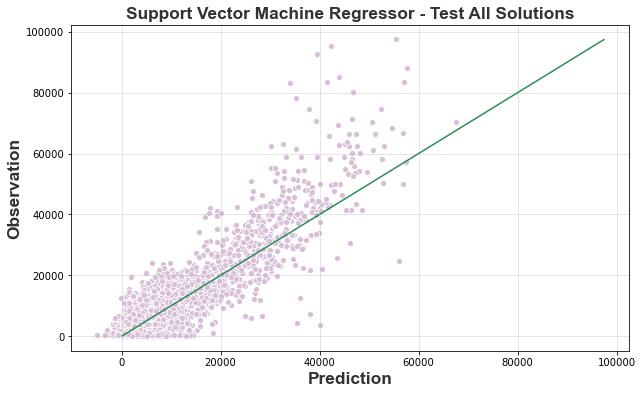

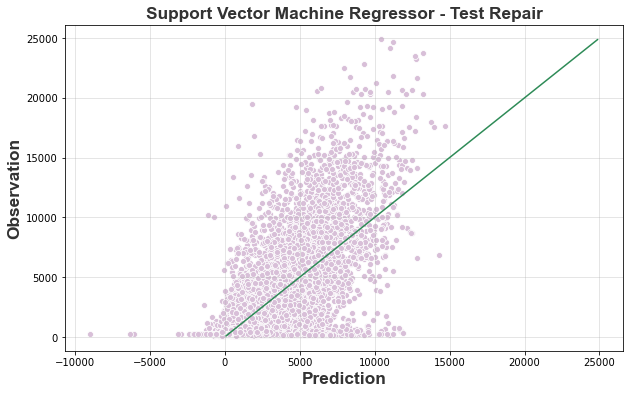

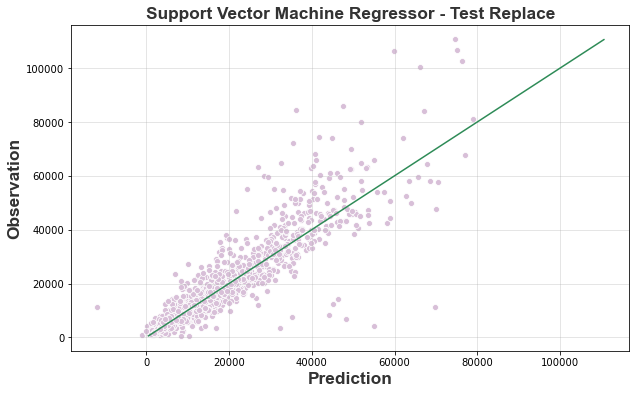

In [23]:
fig, ax = plt.subplots(figsize=(10, 6))
with sns.axes_style('darkgrid'):
    g = sns.scatterplot(x=y_test_pred_SVR,y=y_test['Cost'],ax=ax,color='Thistle')
    g = sns.lineplot(x = y_test['Cost'] , y = y_test['Cost'],color="SeaGreen")
    g.set_xlabel('Prediction',weight='bold',size='xx-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    g.set_ylabel('Observation',weight='bold',size='xx-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    g.set_title('Support Vector Machine Regressor - Test All Solutions',weight='bold',size='xx-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')  
    g.grid(alpha=0.4)
    
    
fig, ax = plt.subplots(figsize=(10, 6))
with sns.axes_style('darkgrid'):
    g = sns.scatterplot(x=y_test_pred_repair_SVR,y=y_test_repair['Cost'],ax=ax,color='Thistle')
    g = sns.lineplot(x = y_test_repair['Cost'] , y= y_test_repair['Cost'], color="SeaGreen")
    g.set_xlabel('Prediction',weight='bold',size='xx-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    g.set_ylabel('Observation',weight='bold',size='xx-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    g.set_title('Support Vector Machine Regressor - Test Repair',weight='bold',size='xx-large',alpha=0.8,family= 'Arial',stretch='extra-expanded') 
    g.grid(alpha=0.4)
    
fig, ax = plt.subplots(figsize=(10, 6))
with sns.axes_style('darkgrid'):
    g = sns.scatterplot(x=y_test_pred_replace_SVR,y=y_test_replace['Cost'],ax=ax,color='Thistle')
    g = sns.lineplot(x = y_test_replace['Cost'] , y= y_test_replace['Cost'], color="SeaGreen")
    g.set_xlabel('Prediction',weight='bold',size='xx-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    g.set_ylabel('Observation',weight='bold',size='xx-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    g.set_title('Support Vector Machine Regressor - Test Replace',weight='bold',size='xx-large',alpha=0.8,family= 'Arial',stretch='extra-expanded') 
    g.grid(alpha=0.4)

<a id="section_ada"></a> 
## **e. Ada Boosting**
[volver a TOC](#section_toc)

In [24]:
# Grilla de parámetros
from sklearn.ensemble import AdaBoostRegressor

param_grid_ABR = [{"preprocessing__numericas__select_num__columns":[numericas_ARS_oficial,numericas_ARS_blue,numericas_USD_oficial,numericas_USD_blue],
                      "preprocessing__categoricas__select_cat__columns":[categoricas_sin_product_code],
        "rgr": [AdaBoostRegressor()]        
        }]
#Fit
y_train_pred_ABR, y_test_pred_ABR,r2_repair_test_ABR,r2_replace_test_ABR = modelado(full_pipe,param_grid_ABR,X_train,X_test,y_train.Cost,y_test.Cost)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:    3.0s remaining:    4.5s
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:    4.6s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done  14 out of  20 | elapsed:    5.2s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:    5.8s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    6.3s finished



Los mejores parametros son: {'preprocessing__categoricas__select_cat__columns': ['Dealer', 'Product_Group', 'Product_SubGroup', 'Manufacturer', 'Model', 'Solution', 'Service_Center'], 'preprocessing__numericas__select_num__columns': ['FX_Sales_Date_Blue', 'FX_Loss_Date_prev_Blue', 'Months_at_loss', 'Product_Purchase_Price'], 'rgr': AdaBoostRegressor()}

R2 en train: 0.6823329178726915
R2 en test: 0.6788913696247612

R2 en train reparaciones: 0.13690548185168594
R2 en test reparaciones: 0.15789799459710852
(6154,)
(6154,)

R2 en train reemplazos: 0.658947747882061
R2 en test reemplazos: 0.6492436804282867
(1514,)
(1514,)


Probaremos como performan los modelos por tipo de solución

In [25]:
#Prueba AdaBoosting por solución
print('\nModelo Reparaciones:')
print('--------------------')
param_grid_repair_ABR = [{"preprocessing__numericas__select_num__columns":[numericas_ARS_oficial,numericas_ARS_blue,numericas_USD_oficial,numericas_USD_blue],
                      "preprocessing__categoricas__select_cat__columns":[categoricas_sin_product_code],
        "rgr": [AdaBoostRegressor()],
        'rgr__loss': ['linear', 'square', 'exponential']
        }]
y_train_pred_repair_ABR, y_test_pred_repair_ABR = modelado(full_pipe,param_grid_repair_ABR,X_train_repair,X_test_repair,y_train_repair.Cost,y_test_repair.Cost)




Modelo Reparaciones:
--------------------
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  52 out of  60 | elapsed:   10.7s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   12.2s finished



Los mejores parametros son: {'preprocessing__categoricas__select_cat__columns': ['Dealer', 'Product_Group', 'Product_SubGroup', 'Manufacturer', 'Model', 'Solution', 'Service_Center'], 'preprocessing__numericas__select_num__columns': ['FX_Sales_Date', 'FX_Loss_Date_prev', 'Months_at_loss', 'Product_Purchase_Price'], 'rgr': AdaBoostRegressor(), 'rgr__loss': 'linear'}

R2 en train: 0.12447410010876248
R2 en test: 0.13023795432022833


In [26]:
print('\nModelo Reemplazos:')
print('--------------------')
param_grid_replace_ABR = [{"preprocessing__numericas__select_num__columns":[numericas_ARS_oficial,numericas_ARS_blue,numericas_USD_oficial,numericas_USD_blue],
                      "preprocessing__categoricas__select_cat__columns":[categoricas_replace],
        "rgr": [AdaBoostRegressor()],
        'rgr__loss': ['linear', 'square', 'exponential']
        }]
y_train_pred_replace_ABR, y_test_pred_replace_ABR = modelado(full_pipe,param_grid_replace_ABR,X_train_replace,X_test_replace,y_train_replace.Cost,y_test_replace.Cost)


Modelo Reemplazos:
--------------------
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  52 out of  60 | elapsed:    3.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    4.1s finished



Los mejores parametros son: {'preprocessing__categoricas__select_cat__columns': ['Dealer', 'Product_Group', 'Product_SubGroup', 'Product_Code', 'Manufacturer', 'Model'], 'preprocessing__numericas__select_num__columns': ['FX_Sales_Date_Blue', 'FX_Loss_Date_prev_Blue', 'Months_at_loss', 'Product_Purchase_Price'], 'rgr': AdaBoostRegressor(loss='square'), 'rgr__loss': 'square'}

R2 en train: 0.6425933976342373
R2 en test: 0.5980076202317612


Vemos que si bien es mejor que el  modelo baseline, no logra acercarse a modelso como XGBoost o Random Forest.

<a id="section_graficos"></a> 
# 2- Gráficos comparativos de los modelos

[volver a TOC](#section_toc)

A continuación se presentan gráficos comparativos entre los resultados de los diferentes modelos

In [27]:
valores = [r2_score(y_train.Cost,y_train_pred_L),r2_score(y_test.Cost,y_test_pred_L),
            r2_score(y_train.Cost,y_train_pred_RF),r2_score(y_test.Cost,y_test_pred_RF),
           r2_score(y_train.Cost,y_train_pred_XG),r2_score(y_test.Cost,y_test_pred_XG),
           r2_score(y_train.Cost,y_train_pred_SVR),r2_score(y_test.Cost,y_test_pred_SVR),
          r2_score(y_train.Cost,y_train_pred_ABR),r2_score(y_test.Cost,y_test_pred_ABR)]
diccionario_plot = {'modelo':['Linear Regression']*2  + ['Random Forest']*2 + ['XGBoost']*2 + ['SVR']* 2 + ['ABR']* 2,
                   'score':['R2 Train','R2 Test','R2 Train','R2 Test','R2 Train','R2 Test','R2 Train','R2 Test','R2 Train','R2 Test'],
                   'valores':valores}
df_plot_barras = pd.DataFrame(diccionario_plot)

En el primer gráfico se representa el Score de R2 para train y test de cada modelo. Se puede observar que todos los modelos tienen un score superior en train que en test. En los modelos XGBoost, SVM y ABR la diferencia no es considerable, en cambio en los modelos de Linear Regression y Random Forest la diferencia puede indicar que los modelos están haciendo Overfitting.

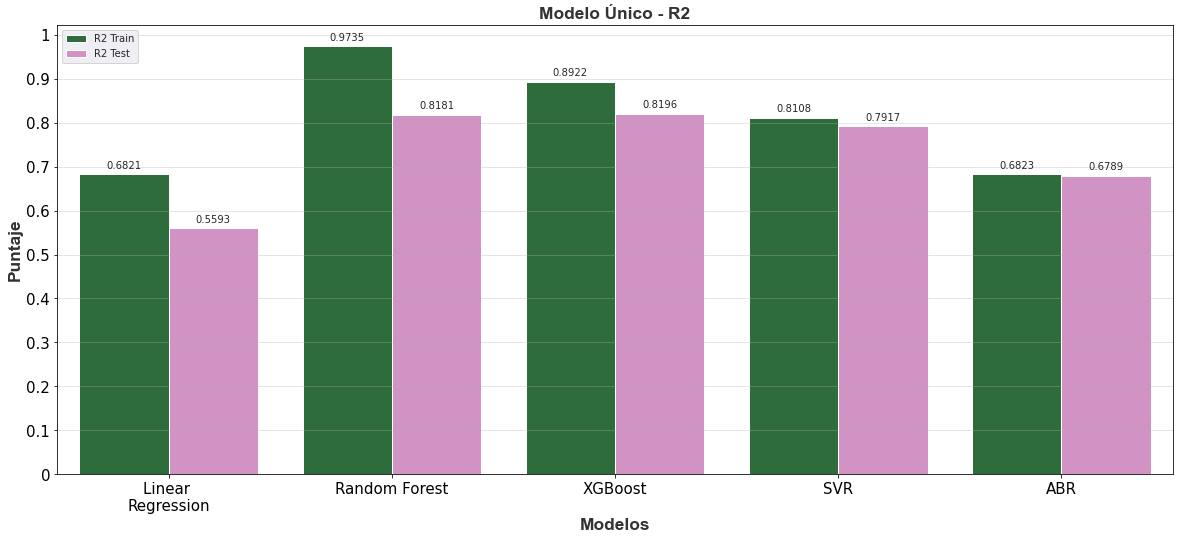

In [30]:
dims = (20,8.27)
fig,ax = plt.subplots(figsize=dims)
with sns.axes_style('darkgrid'):
    g = sns.barplot('modelo','valores',data=df_plot_barras,hue='score',palette=palette,ax=ax,saturation=0.9,order=['Linear Regression', 'Random Forest','XGBoost','SVR','ABR'])
    g.set_xlabel('Modelos',weight='bold',size='xx-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    g.set_ylabel('Puntaje',weight='bold',size='xx-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    g.set_yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
    g.set_title('Modelo Único - R2',weight='bold',size='xx-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    g.set_xticklabels(['Linear \nRegression', 'Random Forest', 'XGBoost','SVR','ABR'],size=15)
    g.set_yticklabels(['0','0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1'],size=15)
    g.legend(loc=2)
    g.grid(axis='y',alpha=0.4)
    figure = g.get_figure()    
    for p in g.patches:
        g.annotate(format(p.get_height(), '.4f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

In [31]:
valores2 = [r2_repair_test_L,r2_replace_test_L,
            r2_repair_test_RF,r2_replace_test_RF,
            r2_repair_test_XG,r2_replace_test_XG,
            r2_repair_test_SVR,r2_replace_test_SVR,
            r2_repair_test_ABR,r2_replace_test_ABR]
diccionario_plot2 = {'modelo':['Linear Regression']*2  + ['Random Forest']*2 + ['XGBoost']*2 + ['SVR']* 2 + ['ABR']* 2,
                   'score':['Repair','Replace','Repair','Replace','Repair','Replace','Repair','Replace','Repair','Replace'],
                   'valores':valores2}
df_plot_barras2 = pd.DataFrame(diccionario_plot2)

A continuación se muestra un gráfico donde se comparan los puntajes de cada modelo por solución. Se puede observar que hay una diferencia considerable. En todos los casos el puntaje es superior para los datos cuya solución es 'Replace'. Esto muestra que aunque el modelo general tenga un buen puntaje, la performance para los datos con solución "Repair" no es comparable.  

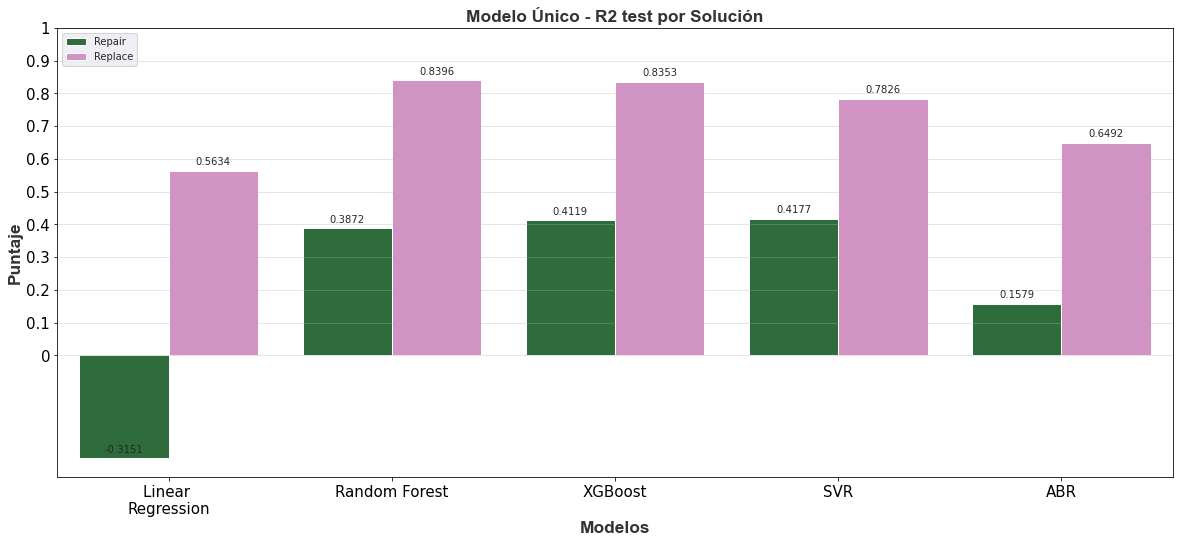

In [32]:
dims = (20,8.27)
fig,ax = plt.subplots(figsize=dims)
with sns.axes_style('darkgrid'):
    g = sns.barplot('modelo','valores',data=df_plot_barras2,hue='score',palette=palette,ax=ax,saturation=0.9,order=['Linear Regression', 'Random Forest','XGBoost','SVR','ABR'])
    g.set_xlabel('Modelos',weight='bold',size='xx-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    g.set_ylabel('Puntaje',weight='bold',size='xx-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    g.set_yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
    g.set_title('Modelo Único - R2 test por Solución',weight='bold',size='xx-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    g.set_xticklabels(['Linear \nRegression', 'Random Forest', 'XGBoost','SVR','ABR'],size=15)
    g.set_yticklabels(['0','0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1'],size=15)
    g.legend(loc=2)
    g.grid(axis='y',alpha=0.4)
    figure = g.get_figure()    
    for p in g.patches:
        g.annotate(format(p.get_height(), '.4f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

In [33]:
valores3 = [r2_repair_test_L,r2_score(y_test_repair.Cost,y_test_pred_repair_L),
            r2_repair_test_RF,r2_score(y_test_repair.Cost,y_test_pred_repair_RF),
            r2_repair_test_XG,r2_score(y_test_repair.Cost,y_test_pred_repair_XG),
            r2_repair_test_SVR,r2_score(y_test_repair.Cost,y_test_pred_repair_SVR),
            r2_repair_test_ABR,r2_score(y_test_repair.Cost,y_test_pred_repair_ABR)]
diccionario_plot3 = {'modelo':['Linear Regression']*2  + ['Random Forest']*2 + ['XGBoost']*2 + ['SVR']* 2 + ['ABR']* 2,
                   'score':['Conjunto','Individual','Conjunto','Individual','Conjunto','Individual','Conjunto','Individual','Conjunto','Individual'],
                   'valores':valores3}
df_plot_barras3 = pd.DataFrame(diccionario_plot3)

Se muestra la comparación entre los puntajes de los modelos con ambas soluciones y el modelo individual. En el primer gráfico se compara con la solución 'Repair' y en el segundo con 'Replace'.

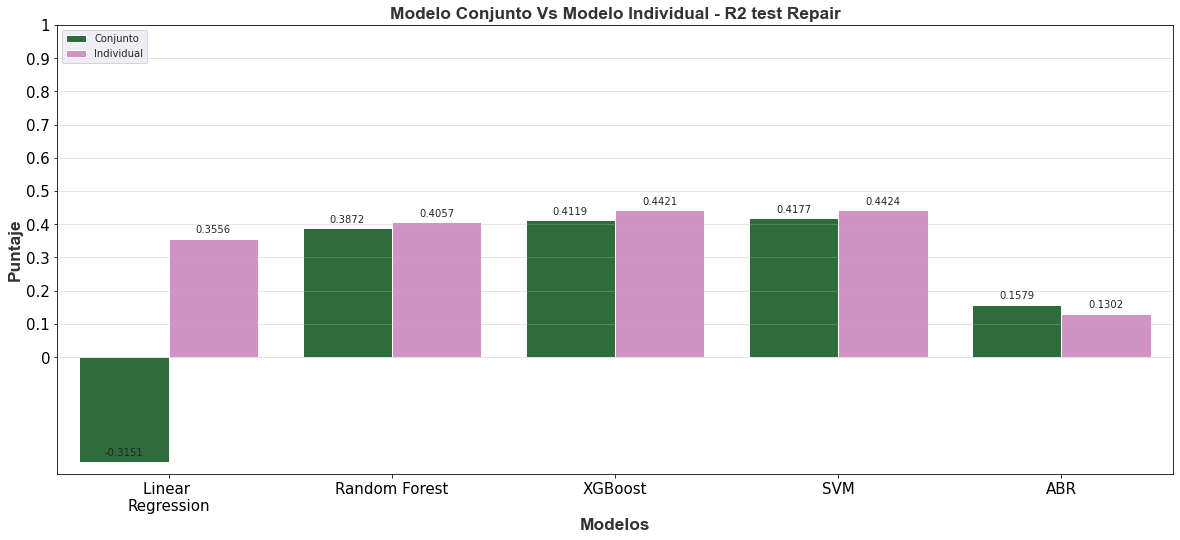

In [34]:
dims = (20,8.27)
fig,ax = plt.subplots(figsize=dims)
with sns.axes_style('darkgrid'):
    g = sns.barplot('modelo','valores',data=df_plot_barras3,hue='score',palette=palette,ax=ax,saturation=0.9,order=['Linear Regression', 'Random Forest','XGBoost','SVR','ABR'])
    g.set_xlabel('Modelos',weight='bold',size='xx-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    g.set_ylabel('Puntaje',weight='bold',size='xx-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    g.set_yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
    g.set_title('Modelo Conjunto Vs Modelo Individual - R2 test Repair',weight='bold',size='xx-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    g.set_xticklabels(['Linear \nRegression', 'Random Forest', 'XGBoost','SVM','ABR'],size=15)
    g.set_yticklabels(['0','0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1'],size=15)
    g.legend(loc=2)
    g.grid(axis='y',alpha=0.4)
    figure = g.get_figure()    
    for p in g.patches:
        g.annotate(format(p.get_height(), '.4f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

In [35]:
valores4 = [r2_replace_test_L,r2_score(y_test_replace.Cost,y_test_pred_replace_L),
            r2_replace_test_RF,r2_score(y_test_replace.Cost,y_test_pred_replace_RF),
           r2_replace_test_XG,r2_score(y_test_replace.Cost,y_test_pred_replace_XG),
           r2_replace_test_SVR,r2_score(y_test_replace.Cost,y_test_pred_replace_SVR),
          r2_replace_test_ABR,r2_score(y_test_replace.Cost,y_test_pred_replace_ABR)]
diccionario_plot4 = {'modelo':['Linear Regression']*2  + ['Random Forest']*2 + ['XGBoost']*2 + ['SVR']* 2 + ['ABR']* 2,
                   'score':['Conjunto','Individual','Conjunto','Individual','Conjunto','Individual','Conjunto','Individual','Conjunto','Individual'],
                   'valores':valores4}
df_plot_barras4 = pd.DataFrame(diccionario_plot4)

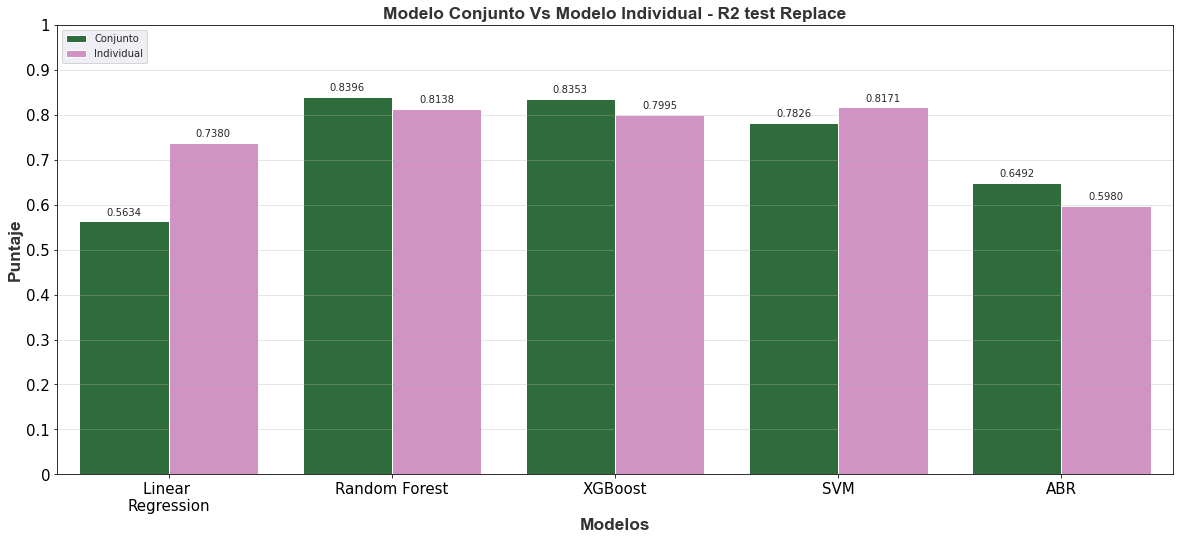

In [36]:
dims = (20,8.27)
fig,ax = plt.subplots(figsize=dims)
with sns.axes_style('darkgrid'):
    g = sns.barplot('modelo','valores',data=df_plot_barras4,hue='score',palette=palette,ax=ax,saturation=0.9,order=['Linear Regression', 'Random Forest','XGBoost','SVR','ABR'])
    g.set_xlabel('Modelos',weight='bold',size='xx-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    g.set_ylabel('Puntaje',weight='bold',size='xx-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    g.set_yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
    g.set_title('Modelo Conjunto Vs Modelo Individual - R2 test Replace',weight='bold',size='xx-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    g.set_xticklabels(['Linear \nRegression', 'Random Forest', 'XGBoost','SVM','ABR'],size=15)
    g.set_yticklabels(['0','0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1'],size=15)
    g.legend(loc=2)
    g.grid(axis='y',alpha=0.4)
    figure = g.get_figure()    
    for p in g.patches:
        g.annotate(format(p.get_height(), '.4f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')